### Timeseries Analysis using NDVI over selected Area

#### Importing of libraries

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

from odc import stac

#### Selecting of Area of Interest using a vector file

In [2]:
area_of_interest = gpd.read_file('data/new_site.geojson')
area_of_interest.explore(column=area_of_interest.columns[0])

####  Loading of data from the Planetary API Stac

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
time_of_interest = "2019-01-01/2019-12-31"

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest.geometry[0],
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 50}},
)
# Check how many items were returned
items = list(search.get_items(),)
print(f"Returned {len(items)} Items")

Returned 32 Items


### Convert STAC data to ODC Data format

In [4]:
ds = stac.load(
    search.get_items(),
    bands=["red", "nir"],
    crs="EPSG:32606",
    resolution=(-30, 30),
    patch_url=pc.sign,
    chunks={'time':1, 'y':1000, 'x': 1000}
)


/srv/conda/envs/notebook/lib/python3.8/site-packages/odc/stac/_eo3.py:313: UserWarning: Common name `rededge` is repeated, skipping
  warn(f"Common name `{alias}` is repeated, skipping")


In [5]:
ds

,Array,Chunk
Bytes,1.60 GiB,1.91 MiB
Shape,"(32, 5180, 5180)","(1, 1000, 1000)"
Count,1187 Tasks,1152 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,1.60 GiB,1.91 MiB
Shape,"(32, 5180, 5180)","(1, 1000, 1000)"
Count,1187 Tasks,1152 Chunks
Type,uint16,numpy.ndarray


### Calculate NDVI

In [6]:
ds["red"] = ds["red"] / 10000
ds["nir"] = ds["nir"] / 10000

In [7]:
ds['NDVI'] = (ds["nir"] - ds["red"]) / (ds["nir"] + ds["red"])

In [8]:
ds.drop(['red','nir'])

,Array,Chunk
Bytes,6.40 GiB,7.63 MiB
Shape,"(32, 5180, 5180)","(1, 1000, 1000)"
Count,8134 Tasks,1152 Chunks
Type,float64,numpy.ndarray


### Compute the timeseries analysis

In [9]:
nvdi_plot = ds['NDVI'].mean(dim=["x","y"]).compute()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


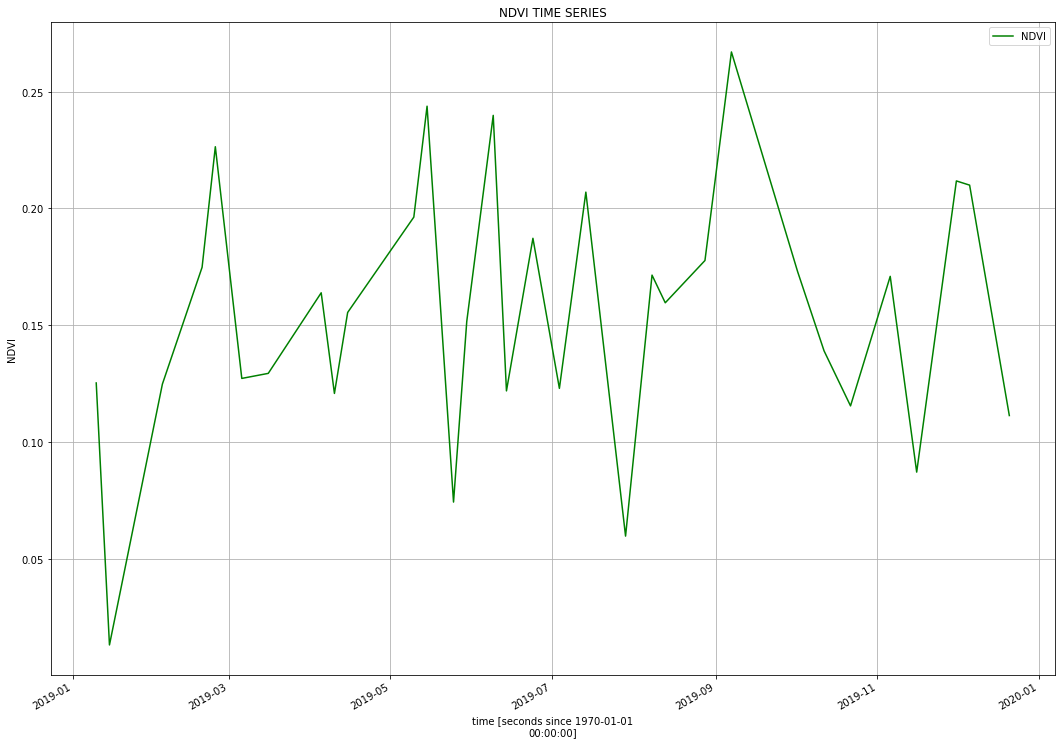

In [10]:
nvdi_plot.plot(color= 'green',label='NDVI', size=12)
plt.legend(loc='best')
plt.title("NDVI TIME SERIES")
plt.grid()

### Plot the Maximum NDVI

In [ ]:
ds['NDVI'].sel(time = max(nvdi_plot).time).plot(cmap='RdYlGn', size=12)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
